# Income Prediction Classifier

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Data Loading

In [3]:
df = pd.read_excel('income_evaluation.xlsx')

## Initial EDA

In [4]:
df_shape = df.shape
print(f"Dataset shape: {df_shape}")
print(df.head())
print(df.info())
print(df.describe(include='all'))

Dataset shape: (32561, 15)
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0

## Missing-Value Check

In [5]:
if df.isnull().sum().sum() > 0:
    print("Missing values summary:\n", df.isnull().sum())

## Feature Encoding and Correlation Matrix

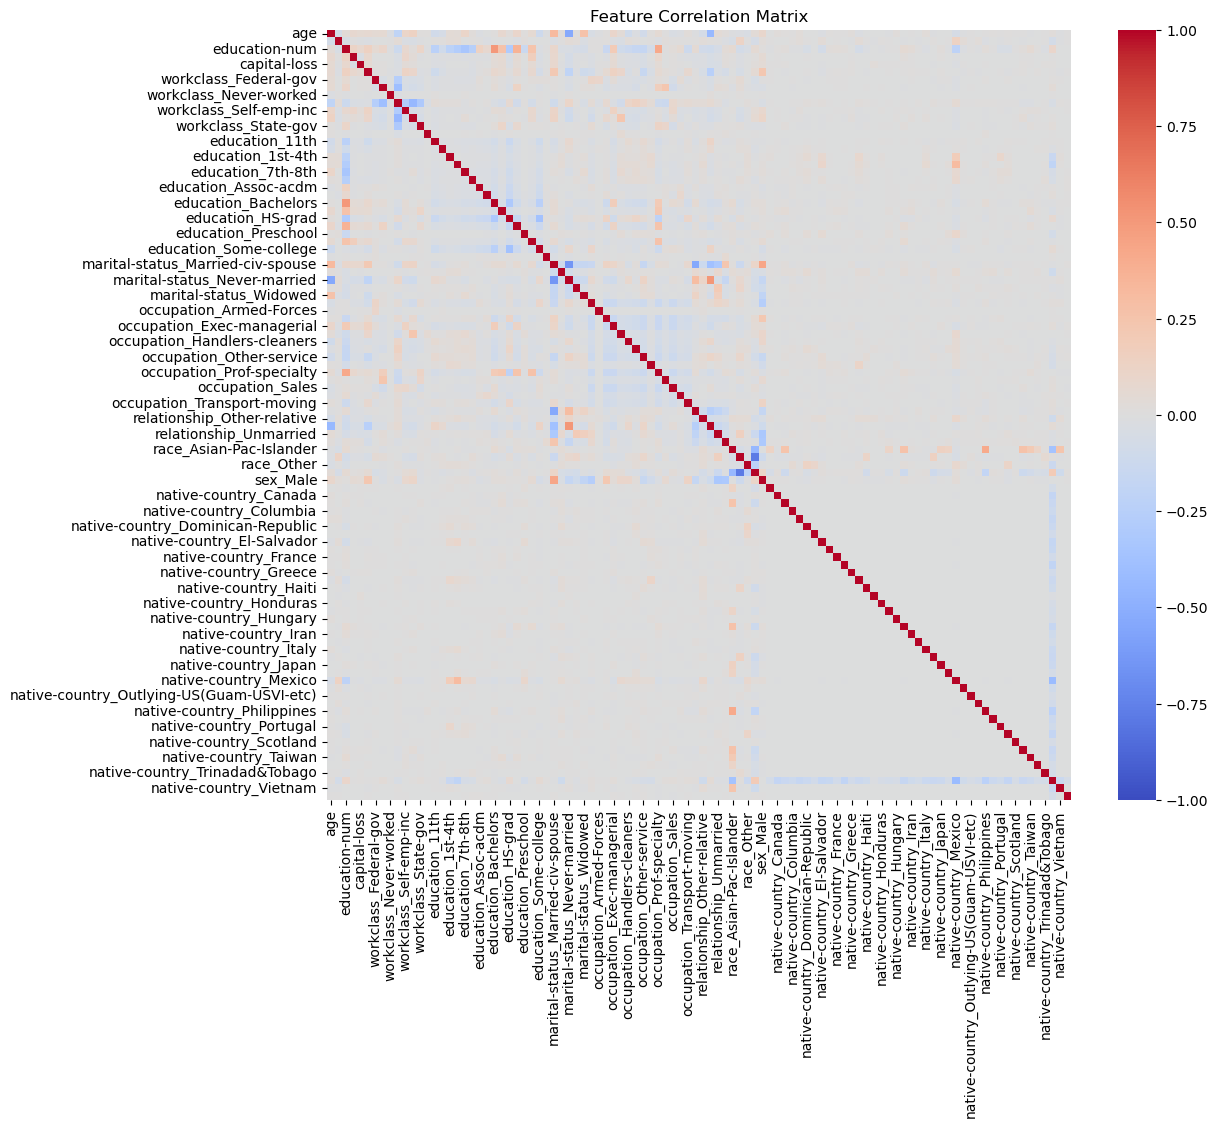

In [6]:
encoded = pd.get_dummies(df.drop('income', axis=1), drop_first=True)
corr = encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

## Data Preparation:

Mainly involves splitting the whole dataset into training and test sets (80 / 20) with stratification on the target to preserve class proportions.

In [7]:
y, X = df['income'], pd.get_dummies(df.drop('income', axis=1), drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## Classifier Definitions

We define a function `build_classifiers()` that returns a dictionary of five commonly used classification algorithms:

- Logistic Regression  
- KNN  
- Decision Tree  
- Random Forest  
- Gradient Boosting

In [8]:
def build_classifiers():
    return {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

models = build_classifiers()

## Model Training and Evaluation

Positive class is defined as `>50K`.

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label='>50K', zero_division=0),
        'Recall':    recall_score(y_test, y_pred, pos_label='>50K', zero_division=0),
        'F1_score':  f1_score(y_test, y_pred, pos_label='>50K', zero_division=0),
        'CV_mean':   cross_val_score(
                          model,
                          X_scaled, y,
                          cv=StratifiedKFold(5, shuffle=True, random_state=42),
                          scoring='accuracy'
                      ).mean(),
        'AUC':       roc_auc_score(
                          y_test.map({'<=50K':0, '>50K':1}),
                          y_prob
                      )
    }

results = []
for name, clf in models.items():
    results.append(evaluate_model(name, clf))

## Results Comparison

Below is the summary table of performance metrics for each model.

In [10]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='F1_score', ascending=False))

                 Model  Accuracy  Precision    Recall  F1_score   CV_mean  \
4    Gradient Boosting  0.869338   0.789346  0.623724  0.696829  0.864930   
3        Random Forest  0.861047   0.749436  0.635204  0.687608  0.855164   
0  Logistic Regression  0.855059   0.736722  0.619260  0.672904  0.851909   
2        Decision Tree  0.813296   0.606538  0.639031  0.622360  0.814348   
1                  KNN  0.825273   0.652266  0.587372  0.618121  0.822395   

        AUC  
4  0.923920  
3  0.909023  
0  0.909313  
2  0.753792  
1  0.845231  
